In [1]:
import os
import re

from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
from time import sleep

from bot.core.exchange.http_api import ExchangeManager, BybitRestAPI
from bot.utils.files import load_tokens_from_file
from bot.utils.coinmarketcap import get_top_tokens
from bot.core.db.postgres_manager import DBManager
from bot.config.credentials import host, user, password, db_name

db_params = {'host': host, 'user': user, 'password': password, 'dbname': db_name}
db_manager = DBManager(db_params)

import pandas as pd
# pd.options.display.float_format = '{:.2f}'.format

import polars as pl
import polars_ols as pls

import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm

In [2]:
def sort_pairs(df: pl.DataFrame) -> pl.DataFrame:
    return df.with_columns([
        pl.when(pl.col("coin1") <= pl.col("coin2")).then(pl.col("coin1")).otherwise(pl.col("coin2")).alias("pair_min"),
        pl.when(pl.col("coin1") <= pl.col("coin2")).then(pl.col("coin2")).otherwise(pl.col("coin1")).alias("pair_max"),
    ]).drop('coin1', 'coin2').rename({'pair_min': 'coin1', 'pair_max': 'coin2'}).select('coin1', 'coin2', pl.exclude('coin1', 'coin2'))

In [3]:
# get_top_tokens(limit=1000, output_file='./bot/config/top_1000_tokens.txt')

#### Скачиваем данные с Bybit

In [4]:
async def get_data(symbol, interval, n_iters):
    df = await exc_manager.get_candles(symbol=symbol, interval=interval, n_iters=n_iters)
    df = df['bybit_linear'].sort_index()
    df['Returns'] = df['Close'].pct_change()
    df['Log_price'] = np.log(df['Close'] + 1)
    df['Log_returns'] = np.log(df['Close']/df['Close'].shift(1))
    return df.dropna()

In [5]:
exc_manager = ExchangeManager()
exc_manager.add_market("bybit_linear", BybitRestAPI('linear'))

In [6]:
res = await get_data(symbol='ADA_USDT', interval='1h', n_iters=1)
res.shape

(999, 11)

In [7]:
top_1000_tokens = load_tokens_from_file("./data/top_1000_tokens.txt")
tokens_to_del = ['USDT', 'USDC', 'LEO', 'USDe']
prices = await exc_manager.get_prices()
prices = prices['bybit_linear']

token_list = [x + '_USDT' for x in top_1000_tokens if x not in tokens_to_del]
token_list = [col for col in token_list if col in prices.keys()]
len(token_list)

495

In [8]:
with open('./bot/config/tokens.txt', 'r') as file:
    current_tokens = [line.strip() for line in file.readlines()]
len(current_tokens)

80

In [9]:
all_ = db_manager.get_orderbooks()
all_tokens = all_['token'].unique().to_list()

In [10]:
# Отбираем только те токены, которые есть в БД с ордербуками
token_list = []

for token in sorted(all_tokens):
    first_date = db_manager.get_oldest_date_in_orderbook(token)
    
    if first_date < datetime(2025, 11, 18, 0, tzinfo=ZoneInfo("Europe/Moscow")):
        token_list.append(token)
len(token_list)

80

In [11]:
# Настройки параметров
interval = '1d'
n_iters = 2
start_date = datetime(2025, 5, 10, tzinfo=ZoneInfo("Europe/Moscow"))
end_date = datetime(2025, 11, 27, tzinfo=ZoneInfo("Europe/Moscow"))
min_volume = 500_000
days_ago = 30 # За сколько последних дней смотреть волатильность
max_volatility = 55.5
max_price = 30

bad_tokens = []
good_tokens = []

In [12]:
main_df = pd.DataFrame()

for token in tqdm(token_list):
    sleep(0.5)
    df = await get_data(symbol=token, interval=interval, n_iters=n_iters)
    df = df.reset_index()

    if df.empty:
        continue
    
    first_date = df['Date'].head(1).item().floor('D')
    last_date = df['Date'].tail(1).item().floor('D')
    
    if first_date > pd.Timestamp('2025-06-10', tz='Europe/Moscow'):
        continue
    if last_date < pd.Timestamp('2025-11-10', tz='Europe/Moscow'):
        continue

    vol_mean = df[-11: -1]['Turnover'].mean()
    vol24 = df.iloc[-2]['Turnover']
    if vol24 < min_volume or vol_mean < min_volume:
        if token in current_tokens:
            print(f'{token} недостаточно торгового объёма (10d_avg: {int(vol_mean):_} / last_24h: {int(vol24):_})')
            bad_tokens.append(token)
        continue
    
    df = df[(df['Date'] > start_date) & (df['Date'] < end_date)]
    df = df.set_index('Date')
    daily_df = df[-days_ago:]
    daily_df['Max_range'] = daily_df['High'] - daily_df['Low']
    daily_df['Max_range_perc'] = (daily_df['High'] - daily_df['Low']) / daily_df['Low'] * 100

    if daily_df['Max_range_perc'].max() > max_volatility:
        if token in current_tokens:
            print(f'{token} высокая волатильность: {daily_df['Max_range_perc'].max():.1f}%')
            bad_tokens.append(token)
        continue

    if daily_df['Close'][-1] > max_price:
        continue

    main_df[f'{token[:-5]}_price'] = df['Close']
    main_df[f'{token[:-5]}_returns'] = df['Returns']
    main_df[f'{token[:-5]}_log_returns'] = df['Log_returns']
    main_df[f'{token[:-5]}_log_price'] = df['Log_price']
    good_tokens.append(token)

  0%|          | 0/80 [00:00<?, ?it/s]

In [13]:
main_df.shape

(201, 320)

In [14]:
len(current_tokens), len(bad_tokens), len(good_tokens)

(80, 0, 80)

In [15]:
[current_tokens.remove(token) for token in bad_tokens]
len(current_tokens)

80

In [16]:
len(good_tokens), len(set(good_tokens))

(80, 80)

#### Distance approach

In [17]:
from bot.utils.data import make_price_df_from_orderbooks_bulk, normalize
import itertools
import math

In [18]:
exc_manager = ExchangeManager()
exc_manager.add_market("bybit_linear", BybitRestAPI('linear'))
coin_information = exc_manager.get_instrument_data()

In [19]:
# Создадим список из датафреймов для удобства пакетной обработки, а также получим кол-во знаков после запятой для округления
max_days = 180 # За сколько дней считать расстояние
tokens = [x[:-5] for x in sorted(good_tokens)]
dfs = []
token_std = {}
token_dist = {}

for token in tokens:
    try:
        df_token = main_df[[f'{token}_price']].rename(columns={f'{token}_price': 'price'})
        df_token['token'] = token
        df_token = pl.from_pandas(df_token, include_index=True).rename({'Date': 'time'}).tail(max_days)
    except KeyError:
        print(token)
        continue
    
    token_std[token] = main_df[[f'{token}_returns']].std()
    token_dist[token] = df_token['price'].max() - df_token['price'].min()
    dfs.append(df_token)

In [20]:
price_df = make_price_df_from_orderbooks_bulk(dfs=dfs, tokens=tokens, trunc='5m')
curr_prices = price_df.drop('time').tail(1).transpose(include_header=True, header_name='coin', column_names=['price'])
price_df.tail(1)

time,1INCH,ADA,AERO,ALGO,APT,ARB,ARKM,ATOM,AVAX,BLUR,BRETT,CELO,CHZ,CRV,DOGE,DOT,DRIFT,DYDX,EGLD,EIGEN,ENA,ENS,ETC,ETHFI,FARTCOIN,FLOW,GALA,GLM,GMT,GRT,HBAR,IMX,INJ,IOTA,IP,JASMY,…,MOODENG,MORPHO,MOVE,NEAR,NXPC,OM,ONDO,OP,ORDI,PENDLE,PLUME,PNUT,POL,RENDER,ROSE,RUNE,SAND,SEI,SPX,STRK,STX,SUI,SUSHI,S,THETA,TIA,TON,TRX,TWT,VET,WCT,WIF,WLD,XLM,XRP,XTZ,ZRO
"datetime[ns, Europe/Moscow]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-11-26 03:00:00 MSK,0.1903,0.4332,0.7212,0.1454,2.259,0.2183,0.248,2.526,14.638,0.03935,0.01752,0.1715,0.02912,0.4362,0.15518,2.348,0.2299,0.2578,7.953,0.6189,0.28,11.725,14.035,0.769,0.3034,0.2352,0.0078,0.2231,0.01895,0.05157,0.14769,0.3241,5.98,0.1172,2.6861,0.007663,…,0.08017,1.5266,0.05138,1.932,0.4252,0.08707,0.5137,0.3225,4.192,2.6984,0.02592,0.08937,0.1377,1.818,0.01543,0.6527,0.1605,0.1401,0.6835,0.1556,0.3218,1.5398,0.3984,0.1118,0.3681,0.6247,1.6,0.27653,1.0867,0.01387,0.1163,0.3826,0.6513,0.25957,2.2261,0.5079,1.3107


In [21]:
price_df.shape, price_df.drop_nans().shape

((180, 81), (180, 81))

In [22]:
normed_df = normalize(df=price_df, method='minimax', shift_to_zero=False)

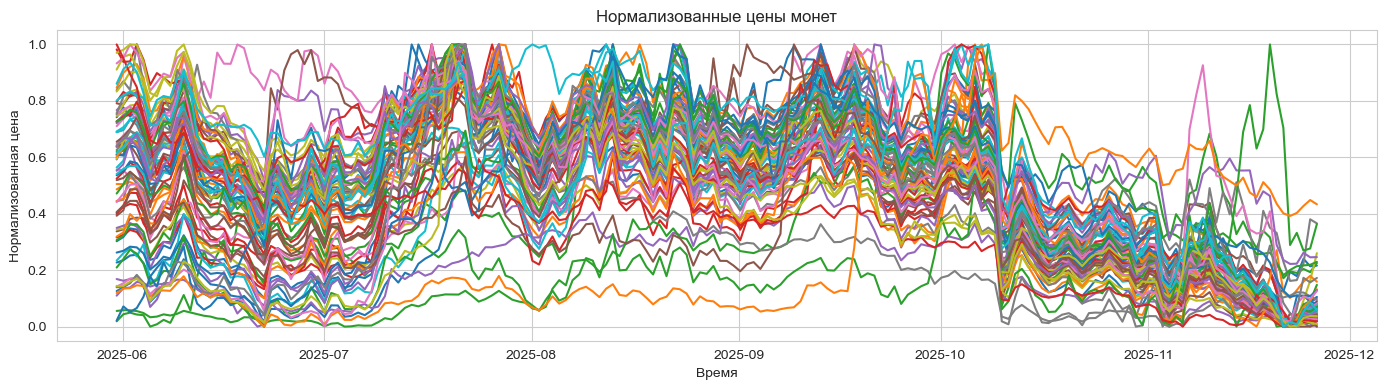

In [23]:
# Нарисуем график с нормализованными ценами
price_cols = [c for c in normed_df.columns if c != 'time']

plt.figure(figsize=(14, 4))
for col in price_cols:
    plt.plot(normed_df['time'].to_list(), normed_df[col].to_list(), label=col)

plt.xlabel("Время")
plt.ylabel("Нормализованная цена")
plt.title("Нормализованные цены монет")
plt.grid(True)
plt.tight_layout()

In [24]:
# Посчитаем евклидово расстояние между парами криптовалют
results = []

# Перебираем все уникальные пары колонок
for col1, col2 in itertools.combinations(price_cols, 2):
    diff_sq = (normed_df[col1] - normed_df[col2]) ** 2
    distance = math.sqrt(diff_sq.sum())
    std = np.std((normed_df[col1] - normed_df[col2]).to_numpy())
    results.append((col1, col2, distance, std))

In [25]:
std_df = pl.DataFrame({"token": list(token_std.keys()), "std_value": list(token_std.values())})
max_dist_df = pl.DataFrame({"token": list(token_dist.keys()), "max_dist": list(token_dist.values())})

In [26]:
dist_df = pl.DataFrame(results, schema=["coin1", "coin2", "dist", "std"], orient="row").sort('dist')
dist_df = dist_df.join(curr_prices, left_on='coin1', right_on='coin').rename({'price': 'price1'})
dist_df = dist_df.join(curr_prices, left_on='coin2', right_on='coin').rename({'price': 'price2'})
dist_df = dist_df.filter(
    (pl.col('price1') / pl.col('price2') < 5) & (pl.col('price1') / pl.col('price2') > 0.2)
)

In [27]:
dist_df = dist_df.join(std_df, left_on="coin1", right_on="token").rename({"std_value": "std_1"})
dist_df = dist_df.join(std_df, left_on="coin2", right_on="token").rename({"std_value": "std_2"})

dist_df = dist_df.join(max_dist_df, left_on="coin1", right_on="token").rename({"max_dist": "dist_1"})
dist_df = dist_df.join(max_dist_df, left_on="coin2", right_on="token").rename({"max_dist": "dist_2"})

In [28]:
dist_df

coin1,coin2,dist,std,price1,price2,std_1,std_2,dist_1,dist_2
str,str,f64,f64,f64,f64,f64,f64,f64,f64
"""GALA""","""VET""",0.440615,0.026974,0.0078,0.01387,0.054883,0.043628,0.012916,0.01562
"""RENDER""","""THETA""",0.573642,0.042448,1.818,0.3681,0.053995,0.053073,2.902,0.6347
"""SAND""","""THETA""",0.575916,0.042432,0.1605,0.3681,0.046419,0.053073,0.1943,0.6347
"""GMT""","""PNUT""",0.650792,0.045642,0.01895,0.08937,0.047361,0.067379,0.0401,0.24894
"""BRETT""","""GALA""",0.679072,0.0505,0.01752,0.0078,0.073979,0.054883,0.05281,0.012916
…,…,…,…,…,…,…,…,…,…
"""DYDX""","""TWT""",7.198198,0.463094,0.2578,1.0867,0.057553,0.044361,0.5089,0.9648
"""ATOM""","""TWT""",7.21261,0.465348,2.526,1.0867,0.041854,0.044361,2.722,0.9648
"""JTO""","""STRK""",7.337131,0.35137,0.5498,0.1556,0.055728,0.074597,1.8339,0.1466


In [29]:
# Добавить фичи: скорость возврата к среднему

In [30]:
#### Cointegration approach

In [31]:
ret_cols = [col for col in main_df.columns if '_log_price' in col]
corr_matrix = main_df[ret_cols].corr()

In [32]:
corr_matrix

,1INCH_log_price,ADA_log_price,AERO_log_price,ALGO_log_price,APT_log_price,ARB_log_price,ARKM_log_price,ATOM_log_price,AVAX_log_price,BLUR_log_price,...,TRX_log_price,TWT_log_price,VET_log_price,WCT_log_price,WIF_log_price,WLD_log_price,XLM_log_price,XRP_log_price,XTZ_log_price,ZRO_log_price
1INCH_log_price,1.000000,0.765408,0.405371,0.904806,0.584459,0.774979,0.646473,0.707011,0.672978,0.626649,...,0.558620,-0.261822,0.684775,0.307159,0.670952,0.572145,0.862157,0.839098,0.799180,0.490696
ADA_log_price,0.765408,1.000000,0.564879,0.875896,0.683769,0.960810,0.789264,0.793092,0.920925,0.672690,...,0.695486,-0.165975,0.772846,0.382615,0.684455,0.749248,0.803262,0.819976,0.825224,0.645776
AERO_log_price,0.405371,0.564879,1.000000,0.443415,0.004188,0.603346,0.082293,0.126436,0.504158,-0.103204,...,0.831360,0.140196,0.052498,-0.371787,-0.015586,0.177556,0.636620,0.687754,0.606081,-0.088041
ALGO_log_price,0.904806,0.875896,0.443415,1.000000,0.664429,0.873869,0.723940,0.795188,0.724629,0.713267,...,0.595072,-0.325252,0.782534,0.376356,0.750721,0.584417,0.886130,0.877421,0.885471,0.569879
APT_log_price,0.584459,0.683769,0.004188,0.664429,1.000000,0.678860,0.910293,0.939392,0.631970,0.905371,...,0.095609,-0.475516,0.922215,0.750429,0.922635,0.698513,0.362873,0.378206,0.428889,0.862269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WLD_log_price,0.572145,0.749248,0.177556,0.584417,0.698513,0.683180,0.856265,0.722278,0.841649,0.706954,...,0.306464,-0.096190,0.727395,0.538362,0.690089,1.000000,0.453939,0.485446,0.474965,0.718287
XLM_log_price,0.862157,0.803262,0.636620,0.886130,0.362873,0.767182,0.431800,0.502518,0.708223,0.377868,...,0.813366,-0.017927,0.460046,0.003940,0.438550,0.453939,1.000000,0.972205,0.887303,0.278513
XRP_log_price,0.839098,0.819976,0.687754,0.877421,0.378206,0.799917,0.456342,0.525292,0.737940,0.387926,...,0.829979,-0.055205,0.477059,-0.006354,0.462671,0.485446,0.972205,1.000000,0.911365,0.264228
XTZ_log_price,0.799180,0.825224,0.606081,0.885471,0.428889,0.816817,0.526201,0.596929,0.691554,0.505769,...,0.738649,-0.170746,0.577022,0.149103,0.539336,0.474965,0.887303,0.911365,1.000000,0.335702


In [33]:
stacked = corr_matrix.stack().reset_index()
stacked.columns = ['stock1', 'stock2', 'correlation']

In [34]:
results = []
processed = []
n_rows = 180 # Сколько последних записей учитывать
total = len(list(itertools.combinations(price_cols, 2)))

for col1, col2 in tqdm(itertools.combinations(price_cols, 2), total=total):
    stock1 = col1 + '_log_price'
    stock2 = col2 + '_log_price'
    
    corr_value = pl.DataFrame(stacked).filter(
            (pl.col('stock1') == stock1) & (pl.col('stock2') == stock2)
        ).select('correlation').item()
    

    data = main_df[[stock1, stock2]].dropna()
    data = data[-n_rows:]

    if data.empty:
        print(f"Пара {stock1}-{stock2} пропущена, т.к. нет данных после очистки")
        continue

    adf_stat_1, p_value_1, _ = coint(data[stock1], data[stock2], trend='c')
    adf_stat_2, p_value_2, _ = coint(data[stock2], data[stock1], trend='c')

    beta_1 = np.cov(data[stock1].values, data[stock2].values)[0, 1] / np.var(data[stock1].values)
    beta_2 = np.cov(data[stock2].values, data[stock1].values)[0, 1] / np.var(data[stock2].values)

    results.append({
        'coin1': col1,
        'coin2': col2,
        'corr': corr_value,
        'adf_1': adf_stat_1,
        'pv_1': p_value_1,
        'adf_2': adf_stat_2,
        'pv_2': p_value_2,
        'beta_1': beta_1,
        'beta_2': beta_2
    })

    processed.append((stock1, stock2))

result_df = pd.DataFrame(results)

  0%|          | 0/3160 [00:00<?, ?it/s]

In [35]:
coint_df = pl.DataFrame(result_df)
coint_df

coin1,coin2,corr,adf_1,pv_1,adf_2,pv_2,beta_1,beta_2
str,str,f64,f64,f64,f64,f64,f64,f64
"""1INCH""","""ADA""",0.765408,-2.589115,0.24124,-1.38385,0.802995,1.745118,0.342696
"""1INCH""","""AERO""",0.405371,-2.471306,0.291868,-2.367364,0.340464,1.471328,0.140767
"""1INCH""","""ALGO""",0.904806,-3.050954,0.098585,-2.467621,0.293533,0.841573,0.995777
"""1INCH""","""APT""",0.584459,-2.4617,0.296217,-0.673011,0.949473,2.807803,0.140526
"""1INCH""","""ARB""",0.774979,-2.988562,0.112949,-1.406756,0.795188,1.46476,0.415035
…,…,…,…,…,…,…,…,…
"""XLM""","""XTZ""",0.887303,-4.414356,0.001687,-4.097469,0.005189,1.219492,0.6607
"""XLM""","""ZRO""",0.278513,-2.359671,0.344186,-2.098599,0.4771,0.994713,0.313993
"""XRP""","""XTZ""",0.911365,-3.700379,0.018305,-3.860837,0.011224,0.61236,1.395031


In [38]:
pair_stats_df = dist_df.drop('price1', 'price2').join(coint_df, on=['coin1', 'coin2'], how='left')
pair_stats_df = pair_stats_df.filter(
    (pl.col('pv_1') < 0.05) & (pl.col('pv_2') < 0.05) &
    (pl.col('dist') > 0.8) & (pl.col('dist') < 1.8) & (abs(pl.col('beta_1') - pl.col('beta_2')) < 1.5)
).rename({'dist': 'spr_dist', 'std': 'spr_std'}).drop('adf_1', 'adf_2')

In [39]:
pair_stats_df

coin1,coin2,dist,std,std_1,std_2,dist_1,dist_2,corr,adf_1,pv_1,adf_2,pv_2,beta_1,beta_2
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""GALA""","""VET""",0.440615,0.026974,0.054883,0.043628,0.012916,0.01562,0.994154,-5.615521,0.00001,-5.595274,0.000011,1.187219,0.8415
"""RENDER""","""THETA""",0.573642,0.042448,0.053995,0.053073,2.902,0.6347,0.980497,-3.693347,0.018689,-3.61404,0.023538,0.527074,1.865551
"""SAND""","""THETA""",0.575916,0.042432,0.046419,0.053073,0.1943,0.6347,0.985708,-4.477733,0.001332,-4.13346,0.004591,2.571562,0.381044
"""GMT""","""PNUT""",0.650792,0.045642,0.047361,0.067379,0.0401,0.24894,0.985533,-3.091917,0.089938,-3.221543,0.066398,5.035141,0.19505
"""BRETT""","""GALA""",0.679072,0.0505,0.073979,0.054883,0.05281,0.012916,0.97911,-3.819645,0.01276,-3.828173,0.012428,0.243137,3.990529
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""DYDX""","""TWT""",7.198198,0.463094,0.057553,0.044361,0.5089,0.9648,-0.509779,-1.758932,0.649447,-1.493775,0.763571,-0.684918,-0.379728
"""ATOM""","""TWT""",7.21261,0.465348,0.041854,0.044361,2.722,0.9648,-0.584201,-0.652638,0.951512,-1.413137,0.792975,-0.500066,-0.70356
"""JTO""","""STRK""",7.337131,0.35137,0.055728,0.074597,1.8339,0.1466,-0.234455,-0.657404,0.951042,-4.063311,0.005821,-0.033996,-4.36239


In [41]:
# Проверка, есть ли такая пара в нашей выборке
token_1 = 'GMT'
token_2 = 'KAS'
pair_stats_df.filter(
    ((pl.col('coin1') == token_1) & (pl.col('coin2') == token_2)) | 
    ((pl.col('coin2') == token_1) & (pl.col('coin1') == token_2))
)

coin1,coin2,dist,std,std_1,std_2,dist_1,dist_2,corr,adf_1,pv_1,adf_2,pv_2,beta_1,beta_2
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""GMT""","""KAS""",1.300729,0.092657,0.047361,0.050394,0.0401,0.07653,0.949737,-1.381148,0.803902,-1.904115,0.577918,1.515465,0.580479


In [40]:
pair_stats_df.write_parquet('./data/pair_selection/all_pairs.parquet')

In [ ]:
# pair_stats_df = pl.read_parquet('./data/pair_selection/curr_pairs.parquet')

In [ ]:
pair_stats_df.filter(
    ((pl.col('coin1') == 'CELO') & (pl.col('coin2') == 'POL')) | 
    ((pl.col('coin1') == 'SEI') & (pl.col('coin2') == 'DYDX'))   |
    ((pl.col('coin1') == 'IOTA') & (pl.col('coin2') == 'MANA'))   |
    ((pl.col('coin1') == 'FLOW') & (pl.col('coin2') == 'MANTA'))    
)

In [ ]:
token_list = []

for row in pair_stats_df.iter_rows(named=True):
    t1 = row["coin1"]
    t2 = row["coin2"]

    if (t1, t2) not in token_list and (t2, t1) not in token_list:
        token_list.append((t1, t2))
len(token_list)

In [ ]:
pairs = db_manager.get_table('pairs', df_type='polars')

for row in pairs.iter_rows(named=True):
    t1 = row['token_1'][:-5]
    t2 = row['token_2'][:-5]
    
    if (t1, t2) not in token_list and (t2, t1) not in token_list:
        token_list.append((t1, t2))
        print((t1, t2))

token_list

In [ ]:
with open('./data/token_pairs.txt', 'w') as file:
    for pair in token_list:
        file.write(f"{pair[0]} {pair[1]}\n")

In [ ]:
current_pairs = []
with open('./bot/config/token_pairs.txt', 'r') as file:
    for line in file:
        a, b = line.strip().split()
        current_pairs.append((a, b))

data_pairs = []
with open('./data/token_pairs.txt', 'r') as file:
    for line in file:
        a, b = line.strip().split()
        data_pairs.append((a, b))

In [ ]:
for token_1, token_2 in [pair for pair in current_pairs if pair not in data_pairs]:
    print(token_1, token_2)

In [ ]:
main_df[[stock1, stock2]].mean()

In [ ]:
import scipy as sc
from statsmodels.graphics.tsaplots import plot_acf

In [ ]:
log_returns = main_df['XRP_log_returns']

In [ ]:
log_returns.plot(figsize=(12,3));

In [ ]:
plot_acf(log_returns);

In [ ]:
log_returns_sq = np.square(log_returns)
log_returns_sq.plot(figsize=(12,3));

In [ ]:
plot_acf(log_returns_sq);

In [ ]:
volatility = log_returns.rolling(window=30).std()*np.sqrt(195)
volatility = volatility.dropna()
volatility.plot(figsize=(12,3));

In [ ]:
import numpy as np
from scipy import stats, optimize

# данные (как у вас)
mu = 5
sigma = 2.5
N = 10000
np.random.seed(1)
x = np.random.normal(loc=mu, scale=sigma, size=N)

def neg_log_lik(theta, x):
    mu_hat, sigma_hat = theta
    if sigma_hat <= 0:
        return 1e20
    return -np.sum(stats.norm.logpdf(x, loc=mu_hat, scale=sigma_hat))

theta0 = [2.0, 3.0]
bounds = [(None, None), (1e-8, None)]   # второе — sigma >= tiny positive

res = optimize.minimize(neg_log_lik, theta0, args=(x,), method='L-BFGS-B', bounds=bounds)
mu_hat, sigma_hat = res.x
print("mu_hat =", mu_hat, "sigma_hat =", sigma_hat)


In [ ]:
import numpy as np
from scipy import stats, optimize

# ---------- симуляция OU ----------
def simulate_ou(kappa, mu, sigma, x0, delta, n_steps, seed=0):
    np.random.seed(seed)
    xs = np.empty(n_steps + 1)
    xs[0] = x0
    phi = np.exp(-kappa * delta)
    var_incr = (sigma**2 / (2 * kappa)) * (1 - np.exp(-2 * kappa * delta))
    for i in range(n_steps):
        mean = mu + (xs[i] - mu) * phi
        xs[i+1] = mean + np.random.normal(scale=np.sqrt(var_incr))
    return xs

# Параметры "истинные"
kappa_true = 1.2
mu_true = 2.5
sigma_true = 0.2
delta = 0.1
n_steps = 2000

x = simulate_ou(kappa_true, mu_true, sigma_true, x0=0.0, delta=delta, n_steps=n_steps, seed=42)

In [ ]:
plt.plot(x);

In [ ]:
spread = (main_df['XRP_log_price'] - main_df['XLM_log_price']).values
spread.mean(), spread.std()

In [ ]:
# ---------- Метод A: регрессия (AR(1)) ----------
X_t = spread[:-1]
X_tp1 = spread[1:]
# регрессия с константой: X_tp1 = a + phi * X_t + eps
# построим OLS вручную
n = len(X_t)
X_design = np.column_stack([np.ones(n), X_t])
beta_hat = np.linalg.lstsq(X_design, X_tp1, rcond=None)[0]  # [a_hat, phi_hat]
a_hat, phi_hat = beta_hat[0], beta_hat[1]
mu_hat_reg = a_hat / (1 - phi_hat)
kappa_hat_reg = -np.log(phi_hat) / delta
residuals = X_tp1 - (a_hat + phi_hat * X_t)
var_res = np.mean(residuals**2)  # MLE uses 1/n (not 1/(n-1))
sigma_hat_reg = np.sqrt( 2 * kappa_hat_reg * var_res / (1 - phi_hat**2) )

print("REGRESSION ESTIMATES:")
print("mu_hat =", mu_hat_reg, "kappa_hat =", kappa_hat_reg, "sigma_hat =", sigma_hat_reg)

In [ ]:
# ---------- Метод B: MLE (оптимизация) ----------
# Негативное лог-правдоподобие, оптимизируем по (log_kappa, mu, log_sigma)
def neg_log_lik_reparam(params, X, delta):
    log_kappa, mu, log_sigma = params
    kappa = np.exp(log_kappa)
    sigma = np.exp(log_sigma)
    phi = np.exp(-kappa * delta)
    # переходные mean и var
    means = mu + (X[:-1] - mu) * phi
    vars_ = (sigma**2 / (2 * kappa)) * (1 - np.exp(-2 * kappa * delta))
    # защита: если какие-то vars_ численно ноль или отрицательны, вернуть большой штраф
    if np.any(vars_ <= 0) or kappa <= 0 or sigma <= 0:
        return 1e30
    # суммируем отрицательные лог-плотности
    nll = -np.sum(stats.norm.logpdf(X[1:], loc=means, scale=np.sqrt(vars_)))
    return nll

In [ ]:
# начальные приближения: можно взять из регрессии
init = [np.log(max(kappa_hat_reg, 1e-6)), mu_hat_reg, np.log(max(sigma_hat_reg, 1e-6))]
res = optimize.minimize(neg_log_lik_reparam, x0=init, args=(spread, delta),
                        method='L-BFGS-B')  # можно и без bounds, т.к. reparam
if not res.success:
    print("Optimization warning:", res.message)

log_kappa_hat, mu_hat_mle, log_sigma_hat = res.x
kappa_hat_mle = np.exp(log_kappa_hat)
sigma_hat_mle = np.exp(log_sigma_hat)

print("\nMLE ESTIMATES:")
print("mu_hat =", mu_hat_mle, "kappa_hat =", kappa_hat_mle, "sigma_hat =", sigma_hat_mle)

In [ ]:
half_life = np.log(2) / kappa_hat_mle  # в часах
print(f"Время полураспада: {half_life:.2f} часов")

In [ ]:
x = np.array(volatility)

In [ ]:
import numpy as np
from scipy.optimize import minimize

# Функция для оценки параметров OU
def ou_ll(params, data):
    theta, mu, sigma = params
    n = len(data)
    dt = 1  # assuming hourly data (time step = 1 hour)
    pred = data[:-1] + theta * (mu - data[:-1]) * dt
    var = sigma**2 * dt
    log_likelihood = -0.5 * (n-1) * np.log(2 * np.pi * var) - np.sum((data[1:] - pred)**2) / (2 * var)
    return -log_likelihood  # минимизируем отрицательное правдоподобие

# Начальные guess параметров
initial_guess = [0.1, np.mean(spread), np.std(spread)]
result = minimize(ou_ll, initial_guess, args=(spread,), method='L-BFGS-B', 
                 bounds=[(1e-6, None), (None, None), (1e-6, None)])

theta_est, mu_est, sigma_est = result.x
print(f"Скорость возврата θ: {theta_est:.4f}")

In [ ]:
mu_est, theta_est, sigma_est

In [ ]:
half_life = np.log(2) / theta_est  # в часах
print(f"Время полураспада: {half_life:.2f} часов")